<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/pytorch_nf_freia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch PlayGround

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    !pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb corner nflows
    !pip install git+https://github.com/VLL-HD/FrEIA.git

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as dist

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logging.info("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


2021-06-29 15:31:17,049:INFO:Using device: cpu


/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Data

In [3]:
from sklearn.datasets import make_moons

n_train = 1_000
data, label = make_moons(n_samples=n_train, noise=0.05)

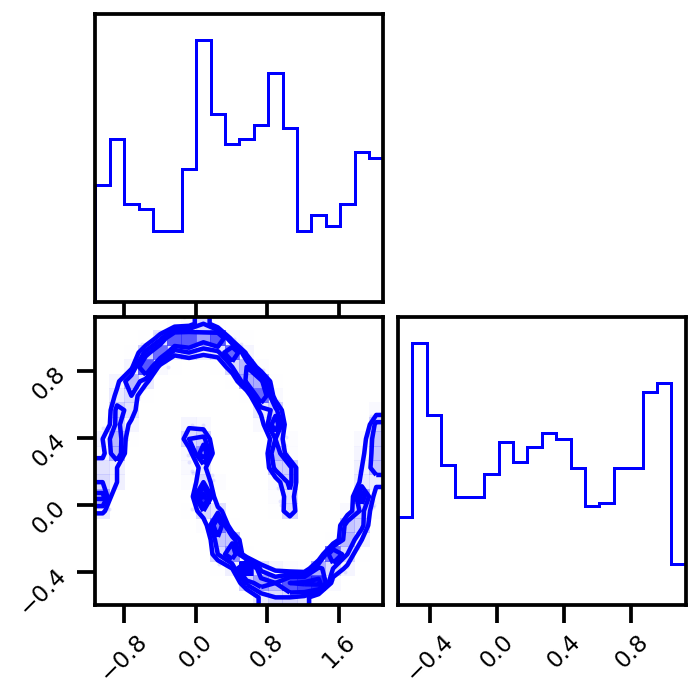

In [4]:
fig = corner.corner(data, hist_factor=2, color="blue")

#### DataLoader

## Model

### Lightning Module

In [14]:
import ml_collections

cfg = ml_collections.ConfigDict()
# Trainer Params
cfg.loss_fn = "inn"
cfg.num_epochs = 150
cfg.learning_rate = 1e-2
cfg.batch_size = 100
cfg.weight_decay = 0.0
cfg.beta1 = 0.9
cfg.beta2 = 0.999
cfg.betas = (cfg.beta1, cfg.beta2)

## Conditional 

#### DataLoader

In [6]:
n_train = 5_000
n_features = 2
n_valid = 1_000
data_train, label_train = make_moons(n_samples=n_train, noise=0.05, random_state=123)
data_valid, label_valid = make_moons(n_samples=n_valid, noise=0.05, random_state=42)
X_train = torch.FloatTensor(data_train)
y_train = torch.FloatTensor(label_train[:, None])
X_valid = torch.FloatTensor(data_valid)
y_valid = torch.FloatTensor(label_valid[:, None])
# make into dataset
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)

# make dataloader
batch_size = 256
num_workers = 8
shuffle = True

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#### Model

In [7]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))


# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(n_features)
for k in range(8):
    inn.append(
        Fm.AllInOneBlock, 
        subnet_constructor=subnet_fc, 
        permute_soft=True, 
        gin_block=False, 
        learned_householder_permutation=2,
        cond=0, cond_shape=(1,))

base_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

#### Initial Transformation

In [8]:
x, y = train_ds[:1000]
z, log_jac_det = inn(x, c=[y])

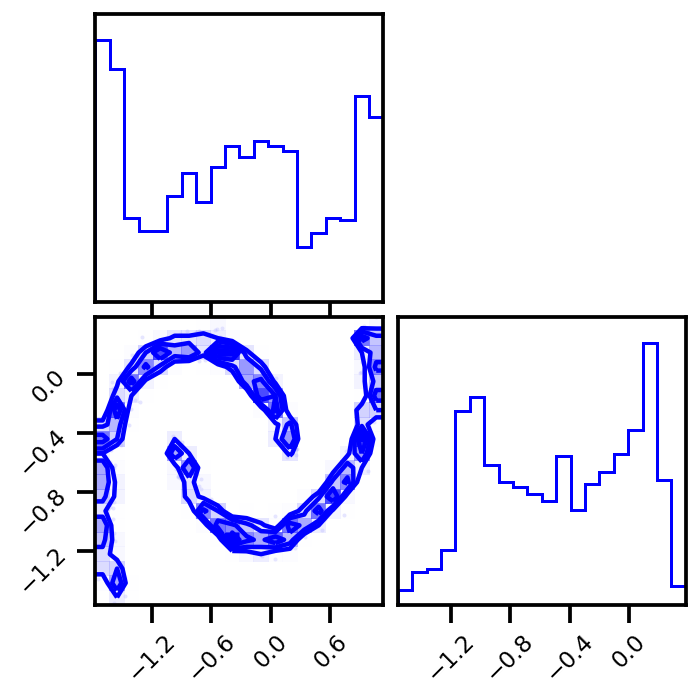

In [9]:
fig = corner.corner(z.detach().numpy(), hist_factor=2, color="blue")

#### Training

In [15]:
from src.lit_plane import CondFlowLearnerPlane

learn = CondFlowLearnerPlane(inn, base_dist, cfg)
trainer = pl.Trainer(
    # epochs
    min_epochs=5, 
    max_epochs=cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=100, 
    # device
    gpus=0,
    # gradient norm
    gradient_clip_val=1.0, 
    gradient_clip_algorithm='norm'
)
trainer.fit(learn, train_dataloader=train_dl, val_dataloaders=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 20.6 K
--------------------------------------
20.6 K    Trainable params
32        Non-trainable params
20.6 K    Total params
0.082     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

#### Latent Space

In [16]:
n_test = 10_000
data_test, label_test = make_moons(n_samples=n_test, noise=0.05)
x = torch.Tensor(data_test)
y = torch.Tensor(label_test[:, None])
z, log_jac_det = learn.model(x, c=[y], jac=False)

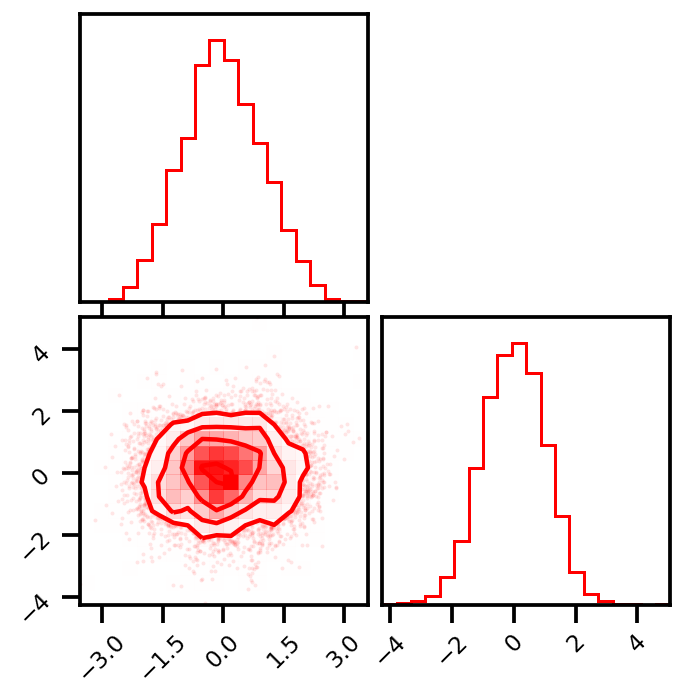

In [17]:
fig = corner.corner(z.detach().numpy(), hist_factor=2, color="red")

#### Inverse Transform

In [18]:
x_ori, _ = learn.model(z, c=[y], rev=True)

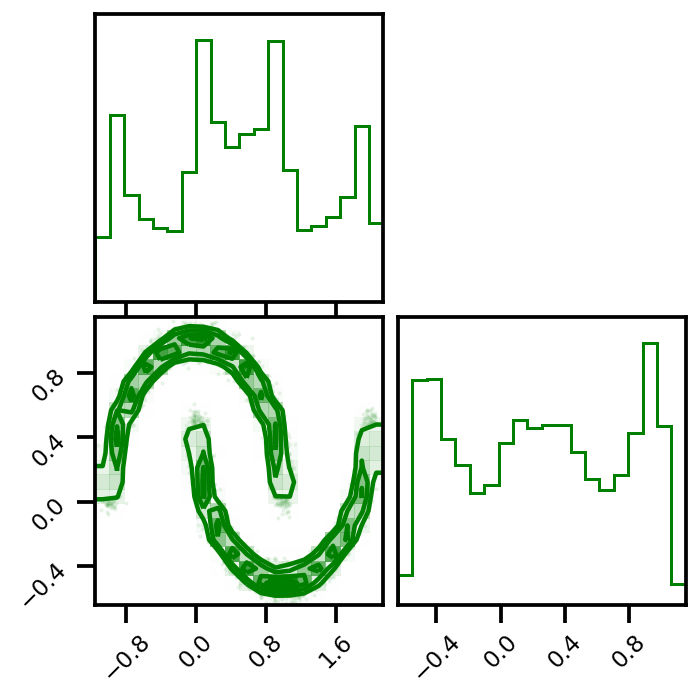

In [19]:
fig = corner.corner(x_ori.detach().numpy(), hist_factor=2, color="green")

#### Sampling

In [20]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 10_000
z = torch.randn(n_samples, n_features)
y = torch.ones((n_samples, 1))
samples, _ = learn.model(z, c=[y], rev=True)

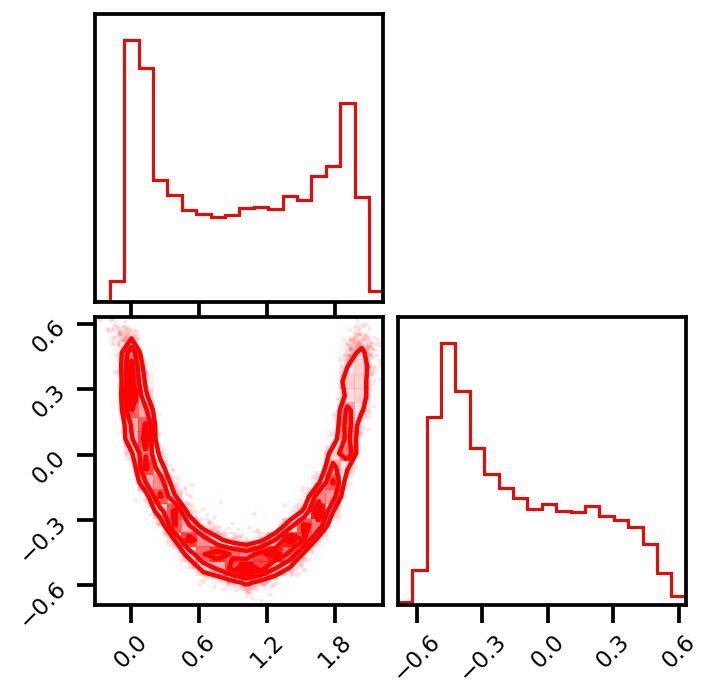

In [21]:
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")

In [22]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 10_000
z = torch.randn(n_samples, n_features)
y = torch.zeros((n_samples, 1))
samples, _ = learn.model(z, c=[y], rev=True)

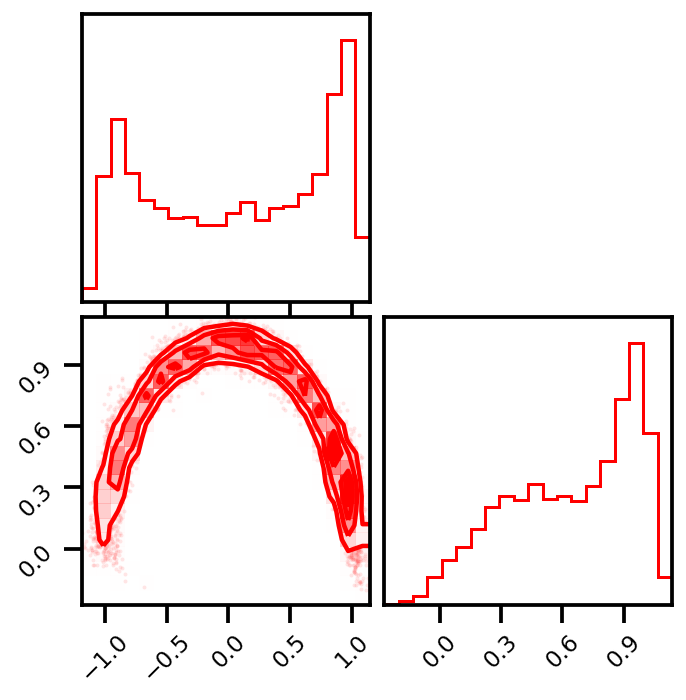

In [23]:
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")